# Install Libraries

In [ ]:
import numpy as np
import pandas as pd
!pip install gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 69.6 MB/s eta 0:00:00


# Load Dataset

In [ ]:
df = pd.read_csv("final_merge_dataset.csv", engine="python", on_bad_lines="skip")
df.head()

Judul  \
0  Viral Isu PHK Buruh Gudang Garam, Said Iqbal: ...   
1         Gempa M 5,3 Guncang Pulau Doi Maluku Utara   
2  Toko Emas Palsu di Riau Dibongkar Polisi, Perh...   
3  Minyakita Tak Sesuai Ukuran juga Ditemukan di ...   
4  Pimpin LDP, Sanae Takaichi Calon Kuat PM Perem...   

                          Waktu  \
0              6 September 2025   
1  Senin, 12 Agu 2024 21:58 WIB   
2   Rabu, 30 Jul 2025 22:22 WIB   
3  Senin, 10 Mar 2025 23:15 WIB   
4    4 Oktober 2025 | 14.00 WIB   

                                                Link  \
0  https://nasional.kompas.com/read/2025/09/06/14...   
1  https://news.detik.com/berita/d-7486691/gempa-...   
2  https://news.detik.com/melindungi-tuah-marwah/...   
3  https://news.detik.com/berita/d-7816829/minyak...   
4  https://www.tempo.co/internasional/pimpin-ldp-...   

                                             Content            tag1  \
0   JAKARTA, KOMPAS.com – Presiden Konfederasi Se...      Said Iqbal   
1  Gempa bumi berkekuatan magnitudo (M) 5,3 mengg...       pulau doi   
2  Satreskrim Polres Bengkalis membongkar praktik...  pemalsuan emas   
3  Polisi mendatangi salah satu gudang Minyakita ...       minyakita   
4  Baca berita dengan sedikit iklan,  klik di sin...          jepang   

              tag2              tag3        tag4                     tag5  \
0   industri rokok   PT Gudang Garam  PHK massal  phk massal 2025 terbaru   
1            gempa               NaN         NaN                      NaN   
2       emas palsu  polres bengkalis  polda riau   melindungi tuah marwah   
3            kudus               NaN         NaN                      NaN   
4  perdana-menteri    sanae-takaichi   perempuan                      ldp   

   source  
0  kompas  
1   detik  
2   detik  
3   detik  
4   tempo

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80472 entries, 0 to 80471
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Judul    80472 non-null  object
 1   Waktu    80472 non-null  object
 2   Link     80472 non-null  object
 3   Content  80463 non-null  object
 4   tag1     78023 non-null  object
 5   tag2     77612 non-null  object
 6   tag3     71602 non-null  object
 7   tag4     56856 non-null  object
 8   tag5     35633 non-null  object
 9   source   80472 non-null  object
dtypes: object(10)
memory usage: 6.1+ MB


In [ ]:
print(df.shape)

(80472, 10)


In [ ]:
df.drop(columns=['Waktu','Link','tag1','tag2','tag3','tag4','tag5'], inplace=True)
df.head()

Judul  \
0  Viral Isu PHK Buruh Gudang Garam, Said Iqbal: ...   
1         Gempa M 5,3 Guncang Pulau Doi Maluku Utara   
2  Toko Emas Palsu di Riau Dibongkar Polisi, Perh...   
3  Minyakita Tak Sesuai Ukuran juga Ditemukan di ...   
4  Pimpin LDP, Sanae Takaichi Calon Kuat PM Perem...   

                                             Content  source  
0   JAKARTA, KOMPAS.com – Presiden Konfederasi Se...  kompas  
1  Gempa bumi berkekuatan magnitudo (M) 5,3 mengg...   detik  
2  Satreskrim Polres Bengkalis membongkar praktik...   detik  
3  Polisi mendatangi salah satu gudang Minyakita ...   detik  
4  Baca berita dengan sedikit iklan,  klik di sin...   tempo

Text(0.5, 1.0, 'News based on Source')

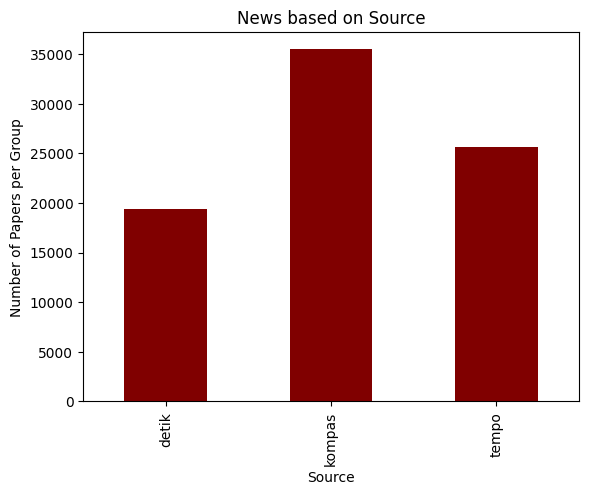

In [ ]:
groups = df.groupby('source')
counts = groups.size()
counts.plot(kind='bar', color='maroon')
plt.xlabel('Source')
plt.ylabel('Number of Papers per Group')
plt.title('News based on Source')

# Preprocessing

In [ ]:
df = df.sample(n=30000, random_state=42).reset_index(drop=True)

In [ ]:
df['text'] = df['Judul'] + ' ' + df['Content']
# Text Preprocessing
df['text'] = df['text'].str.lower()   # Lowercase
df['text'] = df['text'].str.replace(r'[^a-z\s]', '', regex=True)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
!pip install Sastrawi

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Download tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')  # untuk fix LookupError

# Load stopwords Indonesia dari Sastrawi
factory = StopWordRemoverFactory()
stop_words = set(factory.get_stop_words())

# Tambahkan stopwords manual
custom_stopwords = [
    "tersebut", "hingga", "kalau", "beberapa", "kata", "jadi", "kayak", "sini", "terjadi",
    "banget", "merupakan", "kemudian", "katanya", "termasuk", "kali", "enggak", "mengatakan",
    "daripada", "buat", "biar", "supaya", "tak", "terus", "selama","kan", "menjadi"
]

# Gabungkan stopwords manual ke stopwords utama
stop_words.update(custom_stopwords)

# Clean NaN
df['text'] = df['text'].fillna('')

# Tokenization
df['tokens'] = df['text'].apply(word_tokenize)

# Remove stopwords + short words
df['tokens'] = df['tokens'].apply(
    lambda x: [word for word in x if word.lower() not in stop_words and len(word) > 2]
)

df.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Judul  \
0  Wali Kota Malang Beri Dukungan dan Motivasi ke...   
1  Prabowo Beberkan Rencana Pengembangan Komodita...   
2  Curhat ke Rano Karno, Warga Condet: Selama Ini...   
3  Asas Praduga Tak Bersalah, Polri Belum Tetapka...   
4  Sidang Kasus Bentrok Amsterdam: 5 Orang Dihuku...   

                                             Content  source  \
0  Baca berita dengan sedikit iklan,  klik di sin...   tempo   
1  Baca berita dengan sedikit iklan,  klik di sin...   tempo   
2   JAKARTA, KOMPAS.com - Warga Jalan Eretan 2, C...  kompas   
3   JAKARTA, KOMPAS.com - Bareskrim Polri belum m...  kompas   
4  Masih ingat bentrokan di Belanda pada November...   detik   

                                                text  \
0  wali kota malang beri dukungan dan motivasi ke...   
1  prabowo beberkan rencana pengembangan komodita...   
2  curhat ke rano karno warga condet selama ini k...   
3  asas praduga tak bersalah polri belum tetapkan...   
4  sidang kasus bentrok amsterdam  orang dihukum ...   

                                              tokens  
0  [wali, kota, malang, beri, dukungan, motivasi,...  
1  [prabowo, beberkan, rencana, pengembangan, kom...  
2  [curhat, rano, karno, warga, condet, pernah, d...  
3  [asas, praduga, bersalah, polri, tetapkan, ter...  
4  [sidang, kasus, bentrok, amsterdam, orang, dih...

In [ ]:
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# # Create stemmer
# stemmer_factory = StemmerFactory()
# stemmer = stemmer_factory.create_stemmer()

# # Apply stemming/lemmatization
# df['tokens'] = df['tokens'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])

In [ ]:
# Create Dictionary and Corpus
dictionary = corpora.Dictionary(df['tokens'])
dictionary.filter_extremes(no_below=15, no_above=0.5)
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

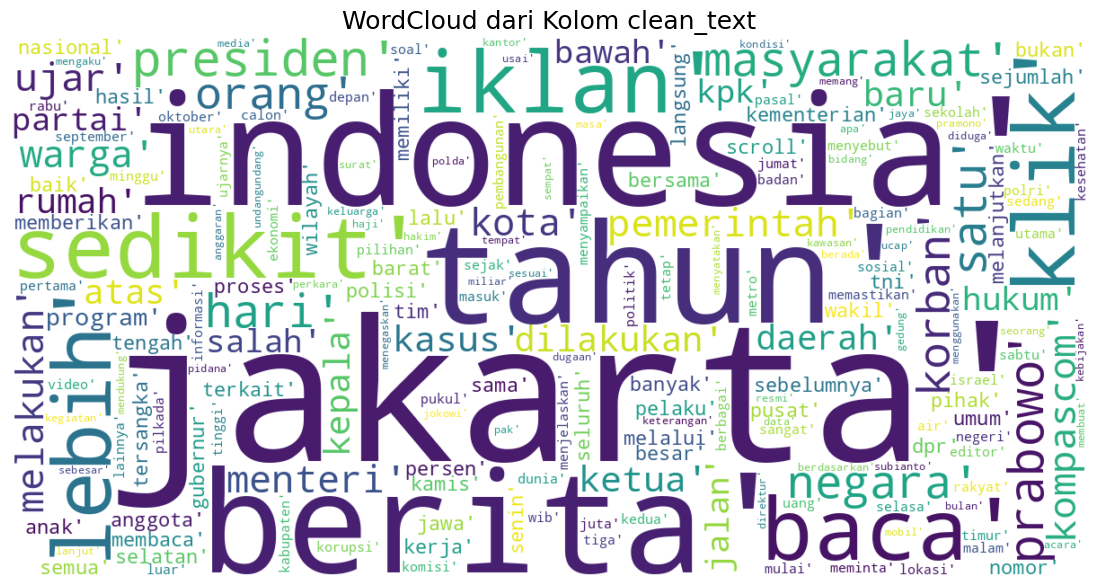

In [ ]:
# Install library jika belum ada
!pip install wordcloud

from wordcloud import WordCloud

# Gabungkan semua teks menjadi 1 string
text_string = " ".join(df['tokens'].astype(str).tolist())

# Membuat wordcloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    max_words=200,
    collocations=False
).generate(text_string)

# Tampilkan
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud dari Kolom clean_text", fontsize=18)
plt.show()


# Modeling

# LDA Model

In [ ]:
num_topics = 10
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

In [ ]:
# Extract topics and print them

topic_words = []
for idx in range(num_topics):
    topic = lda_model.show_topic(idx, topn=10)  # Extract top 10 words for each topic
    words = [word for word, _ in topic]  # Ignore the weights and extract only the words
    topic_words.append(words)
    print(f"Topic {idx}: {' || '.join(words)}")

print("\nTopic words extracted and stored in 'topics_words' list.")

Topic 0: pramono || hari || warga || banyak || lebih || satu || orang || kompascom || acara || salah
Topic 1: korban || polisi || pelaku || metro || rumah || jalan || warga || orang || pukul || polda
Topic 2: berita || baca || sedikit || klik || iklan || membaca || melanjutkan || indonesia || scroll || bawah
Topic 3: hukum || haji || dpr || kasus || kementerian || undangundang || tahun || negara || terkait || indonesia
Topic 4: program || kota || sekolah || pemerintah || daerah || masyarakat || anggaran || kesehatan || kepala || mbg
Topic 5: indonesia || masyarakat || prabowo || negara || nasional || presiden || kerja || menteri || program || ekonomi
Topic 6: sedikit || berita || baca || klik || iklan || persen || indonesia || lebih || tahun || pertamina
Topic 7: israel || negara || gaza || palestina || serangan || militer || orang || trump || lebih || amerika
Topic 8: presiden || prabowo || partai || ketua || dpr || wakil || calon || pilkada || menteri || jokowi
Topic 9: kpk || tni ||

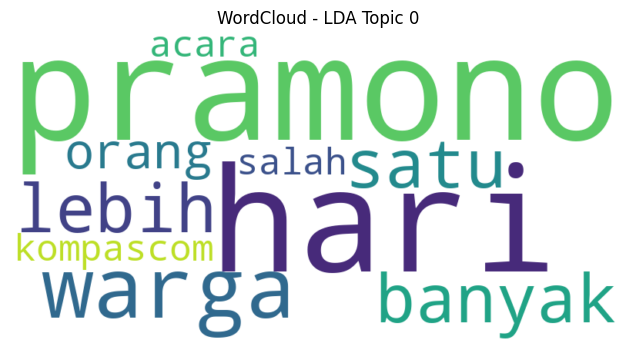

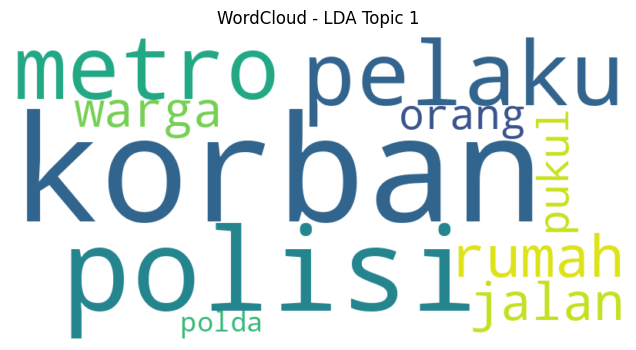

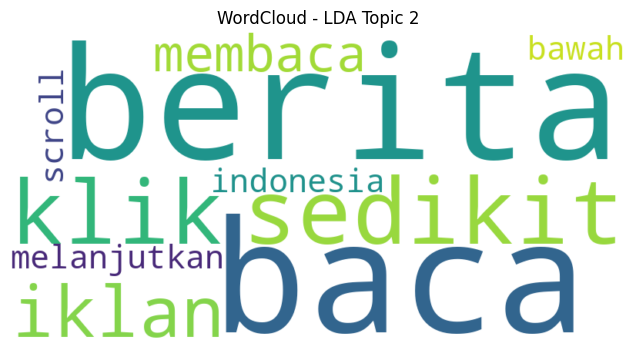

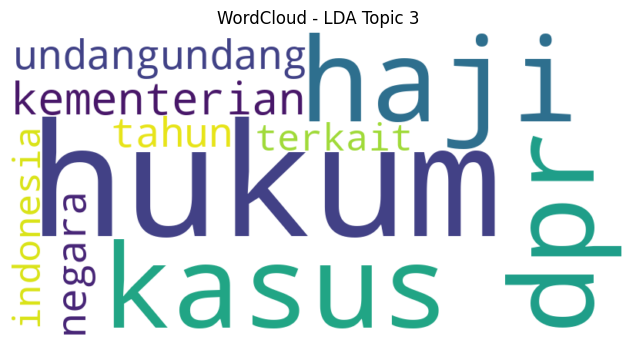

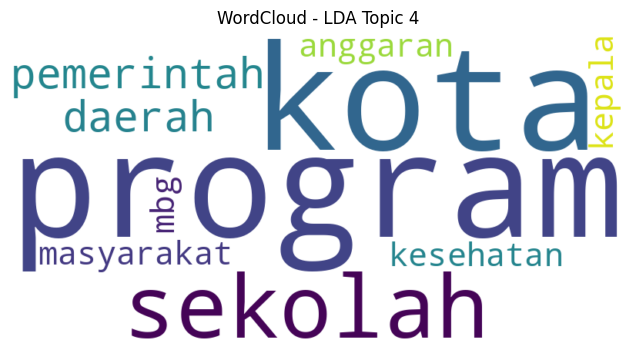

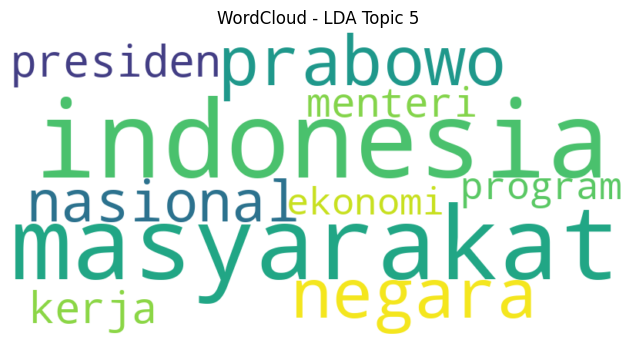

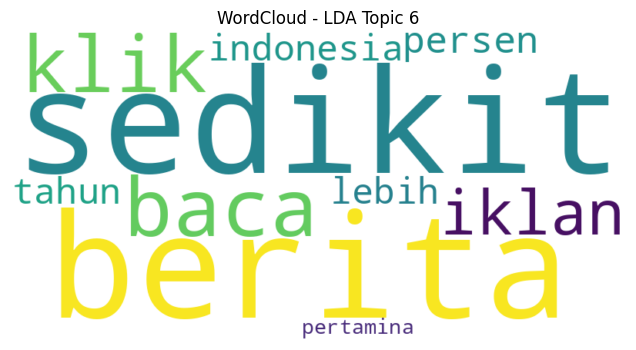

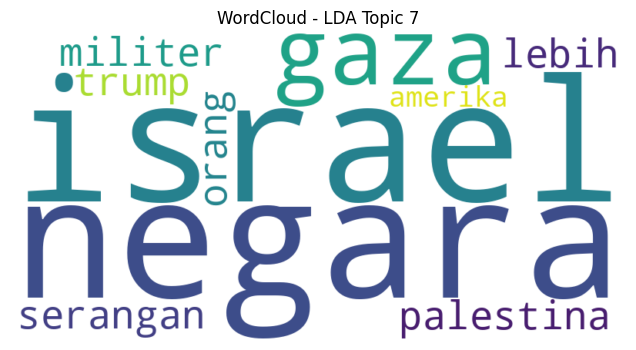

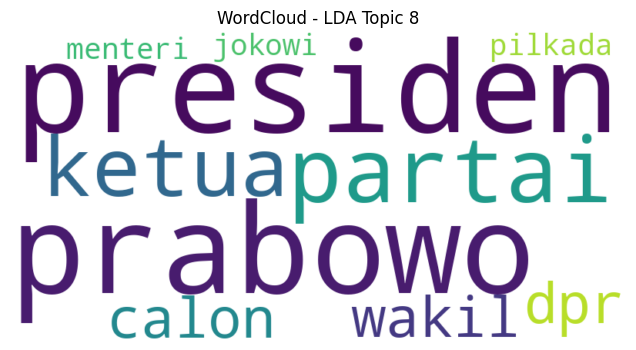

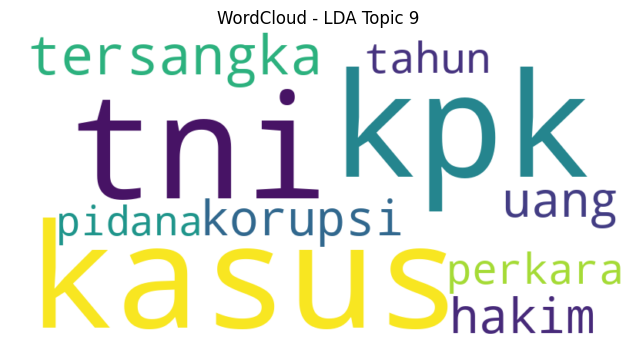

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i, words in enumerate(topic_words):
    text = ' '.join(words)

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(text)

    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - LDA Topic {i}")
    plt.show()


In [ ]:
from gensim.models import CoherenceModel # Import CoherenceModel

topic_coherences = []
for i, topic_word_list in enumerate(topic_words):
    # Create a temporary CoherenceModel for each topic
    # The 'topics' parameter expects a list of lists of words
    # so we wrap the single topic_word_list in another list
    coherence_per_topic = CoherenceModel(topics=[topic_word_list], texts=df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
    score = coherence_per_topic.get_coherence()
    topic_coherences.append(score)
    print(f"Topic {i} Coherence Score: {score}")

# Calculate overall coherence for the LDA model
overall_coherence_score = CoherenceModel(
    model=lda_model, # Use the previously trained lda_model
    texts=df['tokens'],
    corpus=corpus,
    dictionary=dictionary,
    coherence='c_v'
).get_coherence()

print(f"\nOverall Coherence Score: {overall_coherence_score}")

Topic 0 Coherence Score: 0.4103723930475832
Topic 1 Coherence Score: 0.6652133031802292
Topic 2 Coherence Score: 0.8593163691890421
Topic 3 Coherence Score: 0.4997246444513589
Topic 4 Coherence Score: 0.5628889057296289
Topic 5 Coherence Score: 0.583022749613922
Topic 6 Coherence Score: 0.5704213189172204
Topic 7 Coherence Score: 0.7066387192075871
Topic 8 Coherence Score: 0.6980430425690188
Topic 9 Coherence Score: 0.6661833059694636

Overall Coherence Score: 0.562214855481372


# LSA Model

In [ ]:
from gensim.models import TfidfModel

num_topics = 10

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Train LSA
from gensim.models import LsiModel
lsa_model = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics)

In [ ]:
# Extract topics and print them

topic_words = []
for idx in range(num_topics):
    topic = lsa_model.show_topic(idx, topn=10)  # Extract top 10 words for each topic
    words = [word for word, _ in topic]  # Ignore the weights and extract only the words
    topic_words.append(words)
    print(f"Topic {idx}: {' || '.join(words)}")

print("\nTopic words extracted and stored in 'topics_words' list.")

Topic 0: prabowo || korban || kpk || presiden || berita || partai || iklan || klik || indonesia || sedikit
Topic 1: korban || pelaku || prabowo || partai || polisi || presiden || metro || tersangka || pilkada || jokowi
Topic 2: kpk || hasto || korupsi || tersangka || israel || haji || kasus || harun || gaza || masiku
Topic 3: israel || gaza || palestina || pilkada || partai || kpk || serangan || pramono || iran || hamas
Topic 4: israel || gaza || partai || mbg || pilkada || palestina || program || haji || pdip || sekolah
Topic 5: haji || prabowo || tni || pramono || jemaah || puasa || kpk || kuota || gempa || presiden
Topic 6: haji || prabowo || jemaah || pramono || tni || presiden || jokowi || kuota || puasa || korban
Topic 7: mbg || sekolah || bergizi || makan || program || gratis || keracunan || siswa || israel || kpk
Topic 8: gempa || kpk || haji || kebakaran || hasto || tni || prabowo || banjir || pelaku || bmkg
Topic 9: puasa || ramadhan || jadwal || berbuka || tni || haji || iba

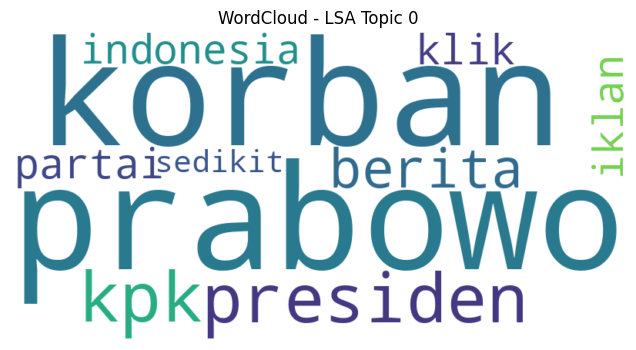

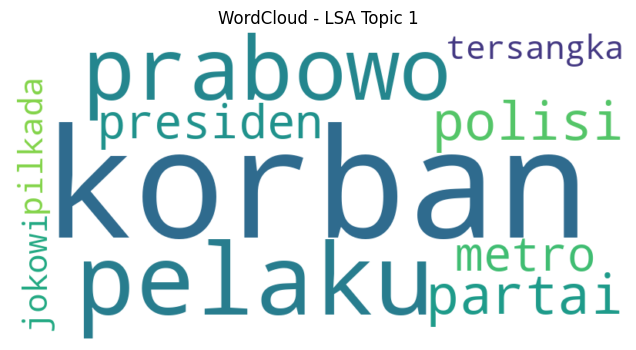

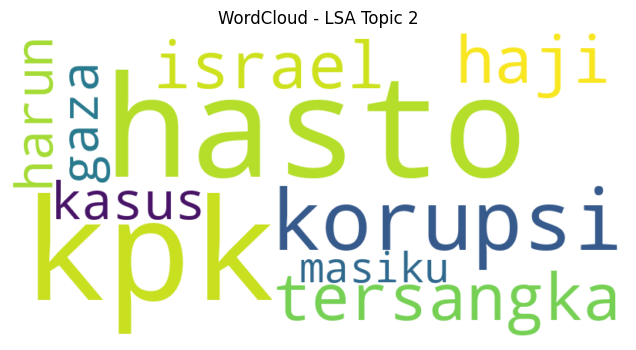

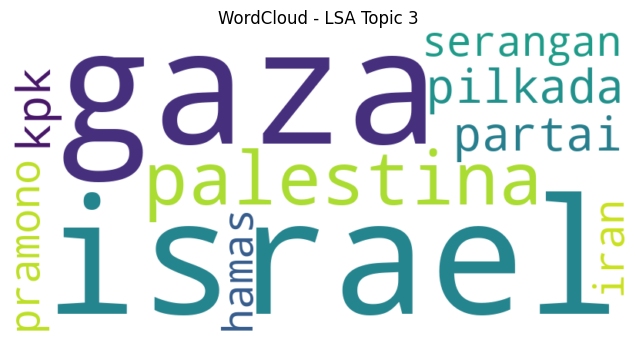

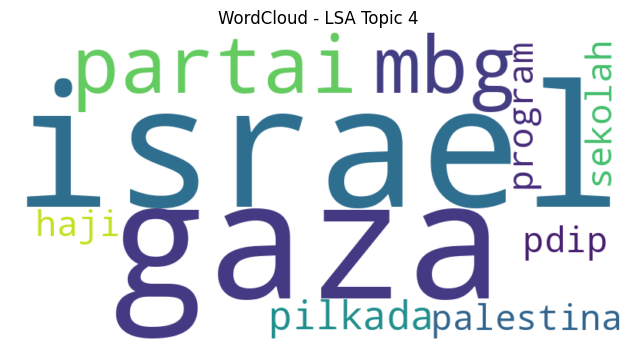

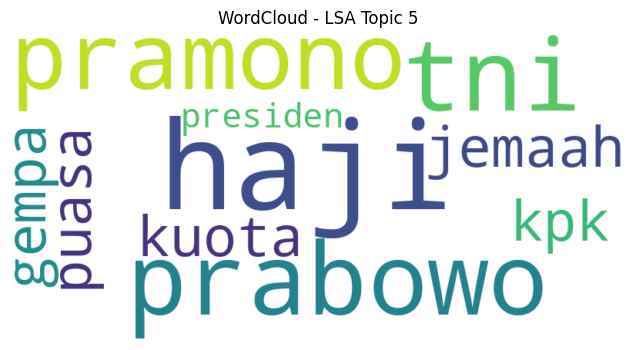

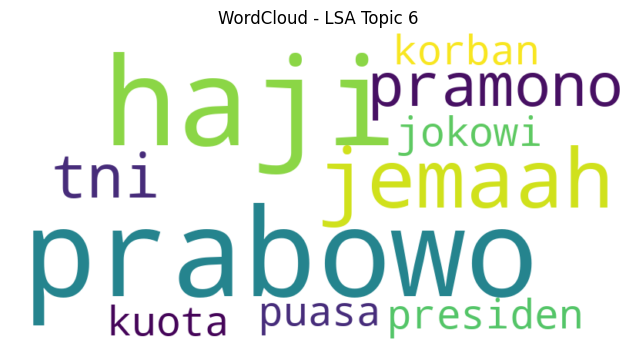

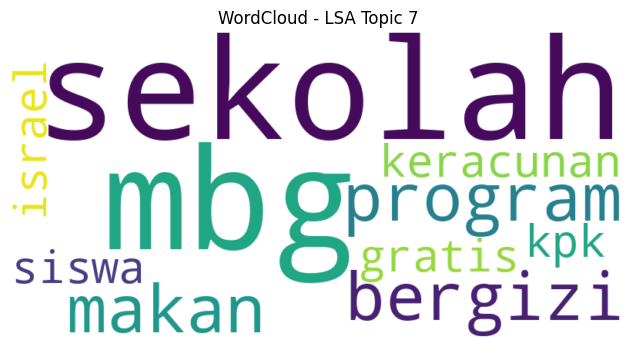

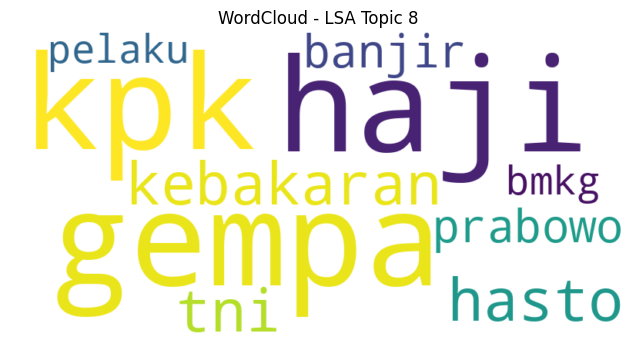

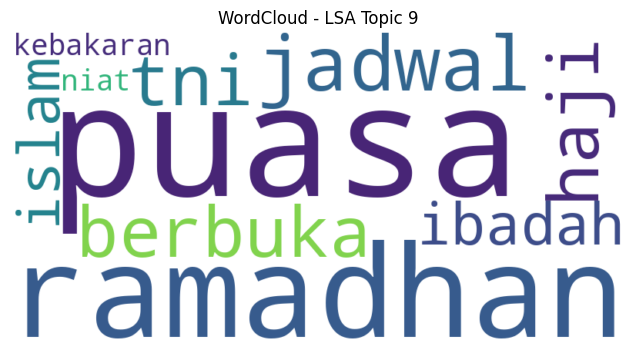

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i, words in enumerate(topic_words):
    text = ' '.join(words)

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(text)

    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - LSA Topic {i}")
    plt.show()


In [ ]:
# Ambil topik LSA dalam format non-formatted
lsa_topics = lsa_model.show_topics(num_topics=num_topics, num_words=20, formatted=False)

# Extract kata-kata saja
topic_words = [[word for word, weight in topic[1]] for topic in lsa_topics]

topic_coherences = []

# Hitung coherence per-topik
for i, topic_word_list in enumerate(topic_words):
    coherence_per_topic = CoherenceModel(
        topics=[topic_word_list],
        texts=df['tokens'],
        corpus=corpus_tfidf,   # Gunakan TF-IDF karena LSA berbasis TF-IDF
        dictionary=dictionary,
        coherence='c_v'
    )
    score = coherence_per_topic.get_coherence()
    topic_coherences.append(score)
    print(f"Topic {i} Coherence Score: {score}")

# Hitung overall coherence
overall_coherence = CoherenceModel(
    model=lsa_model,
    texts=df['tokens'],
    corpus=corpus_tfidf,
    dictionary=dictionary,
    coherence='c_v'
).get_coherence()

print(f"\nOverall Coherence Score (LSA): {overall_coherence}")

Topic 0 Coherence Score: 0.31178907098284236
Topic 1 Coherence Score: 0.28070467580307107
Topic 2 Coherence Score: 0.5716850415323721
Topic 3 Coherence Score: 0.17954372137863134
Topic 4 Coherence Score: 0.1829209958083681
Topic 5 Coherence Score: 0.2334673141891889
Topic 6 Coherence Score: 0.2453876068590068
Topic 7 Coherence Score: 0.44391988030497764
Topic 8 Coherence Score: 0.16454119237924592
Topic 9 Coherence Score: 0.3869683651893576

Overall Coherence Score (LSA): 0.5015104285567552


# Hypertuning LDA

Topic 0 Coherence Score: 0.586315747404363
Topic 1 Coherence Score: 0.5552645888784469
Topic 2 Coherence Score: 0.5504968084050288
Average Coherence Score for 3 Topics: 0.5640257148959462

Topic 0 Coherence Score: 0.5831323142626735
Topic 1 Coherence Score: 0.5886608167961429
Topic 2 Coherence Score: 0.5541445443942934
Topic 3 Coherence Score: 0.6202810002628141
Average Coherence Score for 4 Topics: 0.5865546689289809

Topic 0 Coherence Score: 0.5810568487497776
Topic 1 Coherence Score: 0.3886336973489319
Topic 2 Coherence Score: 0.5892427928264492
Topic 3 Coherence Score: 0.6263310116860143
Topic 4 Coherence Score: 0.5730263826182457
Average Coherence Score for 5 Topics: 0.5516581466458838

Topic 0 Coherence Score: 0.747733916555992
Topic 1 Coherence Score: 0.58138994595518
Topic 2 Coherence Score: 0.4989494509307558
Topic 3 Coherence Score: 0.5343059307363933
Topic 4 Coherence Score: 0.5821080388164451
Topic 5 Coherence Score: 0.767445262413587
Average Coherence Score for 6 Topics: 0

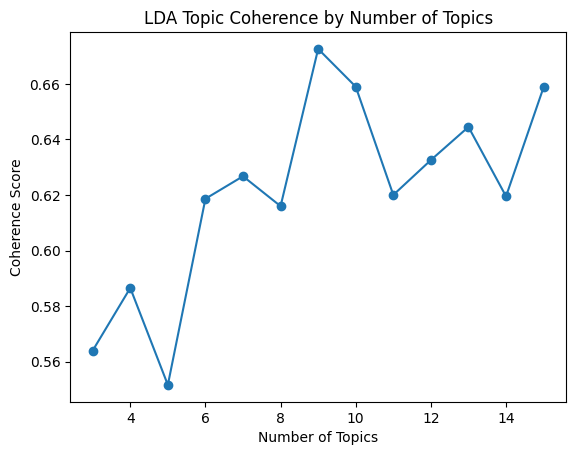

In [ ]:
import gensim
from gensim.models import LdaModel, CoherenceModel, LdaMulticore
import matplotlib.pyplot as plt

# Fungsi untuk menghitung coherence score per jumlah topik
def compute_coherence_scores(corpus, dictionary, df, start, end):
    coherence_scores = []

    for num_topics in range(start, end + 1):
        # Build LDA model
        lda_model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=2)

        # Ambil kata tiap topik
        topics = lda_model.print_topics(num_words=10)
        topic_words = []

        for topic in topics:
            topic_word_list = [
                word.split('*')[1].replace('"', '').strip()
                for word in topic[1].split(' + ')
            ]
            topic_words.append(topic_word_list)

        # Hitung coherence per topik
        topic_coherences = []
        for i, topic_word_list in enumerate(topic_words):
            coherence_per_topic = CoherenceModel(
                topics=[topic_word_list],
                texts=df['tokens'],
                dictionary=dictionary,
                coherence='c_v'
            )
            score = coherence_per_topic.get_coherence()
            topic_coherences.append(score)
            print(f"Topic {i} Coherence Score: {score}")

        # Rata-rata coherence score
        average_coherence = sum(topic_coherences) / len(topic_coherences)
        coherence_scores.append(average_coherence)
        print(f"Average Coherence Score for {num_topics} Topics: {average_coherence}\n")

    return coherence_scores


# ============================
# RANGE 3 SAMPAI 15
# ============================
start, end = 3, 15

coherence_scores = compute_coherence_scores(
    corpus, dictionary, df, start, end
)

# Cari topik terbaik
topic_range = list(range(start, end + 1))
best_num_topics = topic_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal Number of Topics: {best_num_topics}")

# Plot
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('LDA Topic Coherence by Number of Topics')
plt.show()

# Hypertuning LSA

Topic 0 Coherence Score: 0.4741733056020395
Topic 1 Coherence Score: 0.3105935737621652
Topic 2 Coherence Score: 0.44424523709660113
Average Coherence Score for 3 Topics: 0.4096707054869353

Topic 0 Coherence Score: 0.47417330560203946
Topic 1 Coherence Score: 0.31059357376216523
Topic 2 Coherence Score: 0.6137690360025857
Topic 3 Coherence Score: 0.33857467079645365
Average Coherence Score for 4 Topics: 0.43427764654081097

Topic 0 Coherence Score: 0.4741733056020395
Topic 1 Coherence Score: 0.3105935737621652
Topic 2 Coherence Score: 0.4442452370966013
Topic 3 Coherence Score: 0.3385746707964536
Topic 4 Coherence Score: 0.22861845310220677
Average Coherence Score for 5 Topics: 0.3592410480718933

Topic 0 Coherence Score: 0.4741733056020395
Topic 1 Coherence Score: 0.3105935737621652
Topic 2 Coherence Score: 0.4442452370966013
Topic 3 Coherence Score: 0.2562064057115776
Topic 4 Coherence Score: 0.28549384805149264
Topic 5 Coherence Score: 0.4351746907932517
Average Coherence Score for

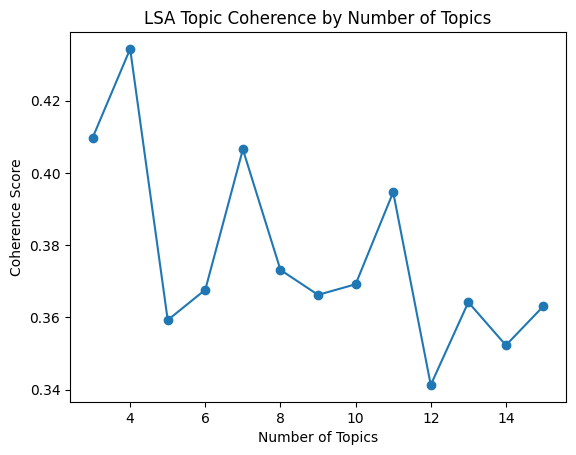

In [ ]:
import gensim
from gensim.models import LsiModel, CoherenceModel
import matplotlib.pyplot as plt

# Fungsi untuk menghitung coherence score per jumlah topik
def compute_coherence_scores(corpus, dictionary, df, start, end):
    coherence_scores = []

    for num_topics in range(start, end + 1):
        # Membangun model LSA
        lsa_model = LsiModel(
            corpus=corpus_tfidf,
            id2word=dictionary,
            num_topics=num_topics
        )

        # Ambil kata-kata di setiap topik
        topics = lsa_model.print_topics(num_topics=num_topics, num_words=10)
        topic_words = []

        for topic in topics:
            topic_word_list = [
                word.split('*')[1].replace('"', '').strip()
                for word in topic[1].split(' + ')
            ]
            topic_words.append(topic_word_list)

        # Hitung coherence per topik
        topic_coherences = []
        for i, topic_word_list in enumerate(topic_words):
            coherence_per_topic = CoherenceModel(
                topics=[topic_word_list],
                texts=df['tokens'],
                dictionary=dictionary,
                coherence='c_v'
            )
            score = coherence_per_topic.get_coherence()
            topic_coherences.append(score)
            print(f"Topic {i} Coherence Score: {score}")

        # Rata-rata coherence score
        average_coherence = sum(topic_coherences) / len(topic_coherences)
        coherence_scores.append(average_coherence)
        print(f"Average Coherence Score for {num_topics} Topics: {average_coherence}\n")

    return coherence_scores


# ============================
# RANGE 3 SAMPAI 15
# ============================
start, end = 3, 15

coherence_scores = compute_coherence_scores(
    corpus_tfidf, dictionary, df, start, end
)

# Topik terbaik
topic_range = list(range(start, end + 1))
best_num_topics = topic_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal Number of Topics: {best_num_topics}")

# Plot
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('LSA Topic Coherence by Number of Topics')
plt.show()


# BERTopic

In [ ]:
!pip install bertopic sentence-transformers umap-learn hdbscan > /dev/null

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd
import re


docs_clean = df['text']

# EMBEDDING MODEL

# Model multilingual (cocok untuk bahasa Indonesia)
embedding_model = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)


# 5. TRAIN BERTopic

topic_model = BERTopic(
    embedding_model=embedding_model,
    language="indonesian",
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs_clean)


# 6. LIHAT TOPIK

print("\n=== Daftar Topik ===")
print(topic_model.get_topic_info().head(10))   # topik awal


# 7. VISUALISASI
# Visualisasi interaktif (muncul di notebook)
fig1 = topic_model.visualize_topics()
fig1.show()

fig2 = topic_model.visualize_barchart()
fig2.show()

fig3 = topic_model.visualize_hierarchy()
fig3.show()


# 8. AMBIL KATA-KATA TIAP TOPIK
# contoh: topik 0
print("\n=== Kata-kata Topik 0 ===")
print(topic_model.get_topic(0))

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-12-14 06:24:20,310 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

2025-12-14 07:14:47,271 - BERTopic - Embedding - Completed ✓
2025-12-14 07:14:47,275 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-14 07:15:50,226 - BERTopic - Dimensionality - Completed ✓
2025-12-14 07:15:50,229 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-14 07:20:31,827 - BERTopic - Cluster - Completed ✓
2025-12-14 07:20:31,847 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-14 07:20:41,491 - BERTopic - Representation - Completed ✓



=== Daftar Topik ===
   Topic  Count                                Name  \
0     -1  12756                  -1_yang_dan_di_itu   
1      0    553       0_mbg_bergizi_keracunan_makan   
2      1    424  1_timnas_pemain_piala_pertandingan   
3      2    365              2_pt_uang_jaksa_miliar   
4      3    345    3_sekolah_guru_pendidikan_rakyat   
5      4    313          4_haji_jemaah_saudi_ibadah   
6      5    296     5_kebakaran_api_terbakar_damkar   
7      6    280        6_anies_pilkada_ridwan_kamil   
8      7    277    7_kecelakaan_truk_menabrak_mobil   
9      8    246      8_narkoba_narkotika_sabu_ganja   

                                      Representation  \
0  [yang, dan, di, itu, dengan, dalam, untuk, jak...   
1  [mbg, bergizi, keracunan, makan, gratis, gizi,...   
2  [timnas, pemain, piala, pertandingan, laga, pe...   
3  [pt, uang, jaksa, miliar, timah, rp, korupsi, ...   
4  [sekolah, guru, pendidikan, rakyat, siswa, swa...   
5  [haji, jemaah, saudi, ibadah, kuo


=== Kata-kata Topik 0 ===
[('mbg', np.float64(0.02982878762927491)), ('bergizi', np.float64(0.02116358951261262)), ('keracunan', np.float64(0.01872761993223055)), ('makan', np.float64(0.017678479694829843)), ('gratis', np.float64(0.0166474001520109)), ('gizi', np.float64(0.016529158831619043)), ('sppg', np.float64(0.016080995209013668)), ('bgn', np.float64(0.014680088390457128)), ('program', np.float64(0.01350009132241013)), ('dadan', np.float64(0.012432892373547852))]


# NMF

Topic 0 Coherence Score: 0.8688234180484115
Topic 1 Coherence Score: 0.6000025948177855
Topic 2 Coherence Score: 0.6568058623583782
Average Coherence Score for 3 Topics: 0.7085439584081917

Topic 0 Coherence Score: 0.8688234180484115
Topic 1 Coherence Score: 0.6239974643489895
Topic 2 Coherence Score: 0.64323534238539
Topic 3 Coherence Score: 0.740653420339405
Average Coherence Score for 4 Topics: 0.719177411280549

Topic 0 Coherence Score: 0.8688234180484115
Topic 1 Coherence Score: 0.6239974643489895
Topic 2 Coherence Score: 0.64323534238539
Topic 3 Coherence Score: 0.7607813815919261
Topic 4 Coherence Score: 0.9310010901533843
Average Coherence Score for 5 Topics: 0.7655677393056204

Topic 0 Coherence Score: 0.8688234180484115
Topic 1 Coherence Score: 0.6239974643489895
Topic 2 Coherence Score: 0.5657366070678332
Topic 3 Coherence Score: 0.7607813815919261
Topic 4 Coherence Score: 0.9362776427879833
Topic 5 Coherence Score: 0.8894764802570274
Average Coherence Score for 6 Topics: 0.

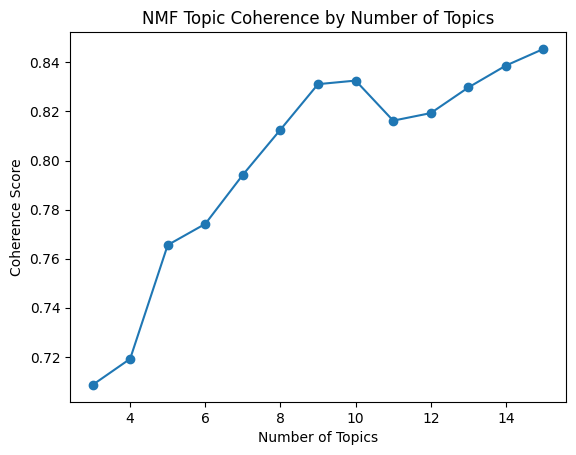

In [ ]:
from sklearn.decomposition import NMF
from gensim.models import CoherenceModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer


# ============================
# FUNGSI COHERENCE NMF
# ============================
def compute_coherence_scores_nmf(tfidf_matrix, feature_names, dictionary, df, start, end):
    coherence_scores = []

    for num_topics in range(start, end + 1):
        # Build NMF model
        nmf_model = NMF(
            n_components=num_topics,
            random_state=42,
            init='nndsvd',
            max_iter=500
        )

        W = nmf_model.fit_transform(tfidf_matrix)
        H = nmf_model.components_

        # Ambil kata-kata tiap topik
        topic_words = []
        for topic_idx, topic in enumerate(H):
            top_indices = topic.argsort()[-10:]
            topic_word_list = [feature_names[i] for i in top_indices]
            topic_words.append(topic_word_list)

        # Hitung coherence per topik
        topic_coherences = []
        for i, topic_word_list in enumerate(topic_words):
            coherence_per_topic = CoherenceModel(
                topics=[topic_word_list],
                texts=df['tokens'],
                dictionary=dictionary,
                coherence='c_v'
            )
            score = coherence_per_topic.get_coherence()
            topic_coherences.append(score)
            print(f"Topic {i} Coherence Score: {score}")

        # Rata-rata coherence score
        average_coherence = np.mean(topic_coherences)
        coherence_scores.append(average_coherence)
        print(f"Average Coherence Score for {num_topics} Topics: {average_coherence}\n")

    return coherence_scores


# ============================
# Generate TF-IDF matrix and feature names
# ============================
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5, # Exclude terms that appear in more than 50% of the documents
    min_df=15,  # Exclude terms that appear in less than 15 documents
    ngram_range=(1, 2) # Consider unigrams and bigrams
)

# Join tokens back into strings for TfidfVectorizer
df['tokens_str'] = df['tokens'].apply(lambda x: ' '.join(x))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['tokens_str'])
feature_names = tfidf_vectorizer.get_feature_names_out()


# ============================
# RANGE 3 SAMPAI 15
# ============================
start, end = 3, 15

coherence_scores = compute_coherence_scores_nmf(
    tfidf_matrix,        # sklearn TF-IDF matrix
    feature_names,       # tfidf_vectorizer.get_feature_names_out()
    dictionary,          # gensim dictionary
    df,
    start,
    end
)

# Topik terbaik
topic_range = list(range(start, end + 1))
best_num_topics = topic_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal Number of Topics (NMF): {best_num_topics}")

# Plot
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('NMF Topic Coherence by Number of Topics')
plt.show()

In [ ]:
# import gensim
# from gensim.models import LdaMulticore, CoherenceModel
# import pickle

# # === Train LDA Model with the Optimal Number of Topics ===
# best_num_topics = 10

# lda_model_best = LdaMulticore(
#     corpus=corpus,
#     num_topics=best_num_topics,
#     id2word=dictionary,
#     passes=10,
#     workers=2
# )

# # === Extract topic words ===
# topics = lda_model_best.print_topics(num_words=10)
# topic_words = []

# for topic in topics:
#     words = [w.split('*')[1].replace('"', '').strip() for w in topic[1].split(' + ')]
#     topic_words.append(words)

# # === Compute coherence score ===
# topic_coherences = []
# for topic_word_list in topic_words:
#     coh_model = CoherenceModel(
#         topics=[topic_word_list],
#         texts=df['tokens'],
#         corpus=corpus,
#         dictionary=dictionary,
#         coherence='c_v'
#     )
#     topic_coherences.append(coh_model.get_coherence())

# average_coherence = sum(topic_coherences) / len(topic_coherences)

# print(f"Average Coherence Score for {best_num_topics} Topics: {average_coherence}")

# # === Save Model as model.pkl ===
# with open("model.pkl", "wb") as f:
#     pickle.dump(lda_model_best, f)

# print("Model saved as model.pkl")